In [3]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
sns.set()
%config InlineBackend.figure_format='retina'

### Data Loading

In [4]:
# Google Colab
%cd "drive/My Drive/internship-2020"

/content/drive/My Drive/internship-2020


In [ ]:
from flt3_data_loading import km_normed_1, flt3_filtered

# Test split sizes (add up to 1)
train_size = 0.6
valid_size = 0.2
test_size = 0.2

# Normalised Difference Dataset
# mean_negs = np.mean(np.array(km_normed_1[np.array(flt3_filtered) == 0]), axis=0)
# km_normed_1 -= mean_negs

# Separating out negatives & positives
negatives = []
positives = []
for pat_i in range(len(km_normed_1)):
    if flt3_filtered[pat_i] == 1:
        if len(positives) == 0:
            positives = np.concatenate((positives, np.array(km_normed_1.iloc[pat_i])))
        else:
            positives = np.vstack((positives, np.array(km_normed_1.iloc[pat_i])))
    elif flt3_filtered[pat_i] == 0:
        if len(negatives) == 0:
            negatives = np.concatenate((negatives, np.array(km_normed_1.iloc[pat_i])))
        else:
            negatives = np.vstack((negatives, np.array(km_normed_1.iloc[pat_i])))

# Add randomness to splitting
np.random.shuffle(negatives)
np.random.shuffle(positives)

# Splitting sets
num_pos = len(positives)
num_neg = len(negatives)
sum_sizes = train_size + valid_size + test_size
ps1, ps2 = math.floor(train_size*num_pos), math.floor((train_size+valid_size)*num_pos)
ns1, ns2 = math.floor(train_size*num_neg), math.floor((train_size+valid_size)*num_neg)
train_set = np.concatenate((negatives[:ns1], positives[:ps1]))
valid_set = np.concatenate((negatives[ns1:ns2], positives[ps1:ps2]))
test_set = np.concatenate((negatives[ns2:], positives[ps2:]))
n_neg_train, n_neg_val, n_neg_test = ns1, (ns2-ns1), (num_neg-ns2)
n_pos_train, n_pos_val, n_pos_test = ps1, (ps2-ps1), (num_pos-ps2)
train_label = [0] * n_neg_train + [1] * n_pos_train
valid_label = [0] * n_neg_val + [1] * n_pos_val
test_label = [0] * n_neg_test + [1] * n_pos_test

# Oversample each set
n_extra_pos_train, n_extra_pos_val, n_extra_pos_test = n_neg_train-n_pos_train, n_neg_val-n_pos_val, n_neg_test-n_pos_test
over_train = np.array([]).reshape((0,km_normed_1.shape[1]))
over_valid = np.array([]).reshape((0,km_normed_1.shape[1]))
over_test = np.array([]).reshape((0,km_normed_1.shape[1]))
i,j,k = 0,0,0
while len(over_train) < n_extra_pos_train:
    over_train = np.concatenate((over_train, train_set[n_neg_train + i % n_pos_train].reshape(1,km_normed_1.shape[1])))
    train_label += [1]
    i += 1
while len(over_valid) < n_extra_pos_val:
    over_valid = np.concatenate((over_valid, valid_set[n_neg_val + j % n_pos_val].reshape(1,km_normed_1.shape[1])))
    valid_label += [1]
    j += 1
while len(over_test) < n_extra_pos_test:
    over_test = np.concatenate((over_test, test_set[n_neg_test + k % n_pos_test].reshape(1,km_normed_1.shape[1])))
    test_label += [1]
    k += 1
oc_train_set = np.concatenate((train_set, over_train))
oc_valid_set = np.concatenate((valid_set, over_valid))
oc_test_set = np.concatenate((test_set, over_test))

train_and_label = [(oc_train_set[i],train_label[i]) for i in range(len(train_label))]
valid_and_label = [(oc_valid_set[i],valid_label[i]) for i in range(len(valid_label))]
test_and_label = [(oc_test_set[i],test_label[i]) for i in range(len(test_label))]

# Data samplers & loaders
batch_size = 64
num_workers = 0
train_sampler = SubsetRandomSampler(range(len(train_and_label)))
valid_sampler = SubsetRandomSampler(range(len(valid_and_label)))
test_sampler = SubsetRandomSampler(range(len(test_and_label)))
train_loader = torch.utils.data.DataLoader(train_and_label,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_and_label,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_and_label,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=num_workers)

In [ ]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)
print(ns1, ns2, ps1, ps2)
print(len(oc_train_set),len(oc_valid_set),len(oc_test_set))
print(len(train_label), len(valid_label), len(test_label))
print(train_label[ns1])

(271, 3796)
(90, 3796)
(91, 3796)
192 256 79 105
384 128 128
384 128 128
1


### Data Visualisation

In [ ]:
# Mean per patient of log10 data
from flt3_data_loading import km_flog10, flt3_filtered
positives = np.array(km_flog10.iloc[[i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]])
negatives = np.array(km_flog10.iloc[[i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]])
plt.hist(np.mean(negatives,axis=1), bins=25, alpha = 0.5, label='negatives', density=True)
plt.hist(np.mean(positives,axis=1), bins=25, alpha = 0.5, label='positives', density=True)
plt.title("Distribution of means per patient of log10 transformed data")
plt.show()

ModuleNotFoundError: ignored

In [ ]:
# Coverage for positive & negative patients (norm1)
from transforms import transform_log10, norm_1
import seaborn as sns
sns.set()
test_pos = norm_1(transform_log10(positives))
test_neg = norm_1(transform_log10(negatives))
plt.hist(np.mean(test_neg, axis=1), bins=50, alpha=0.5, density=True)
plt.hist(np.mean(test_pos, axis=1), bins=50, alpha=0.5, density=True)
plt.title("Coverage for negative & positive patients")
plt.show()

ModuleNotFoundError: ignored

In [ ]:
# Raw data before log and normalisation
from flt3_data_loading import kmer_table_filtered, flt3_filtered
negatives = np.array(kmer_table_filtered[np.array(flt3_filtered) == 0])
positives = np.array(kmer_table_filtered[np.array(flt3_filtered) == 1])

In [ ]:
# Faulty normalisation!
from transforms import norm_1
foo = np.array(
    [[52, 52, 0],
     [26, 26, 40]
     ])
print(foo)
print(np.mean(foo, axis=1))
print(norm_1(foo))
np.mean(norm_1(foo), axis=1)

In [ ]:
# Fixed normalisation
from transforms import norm_1
foo = np.array(
    [[52, 52, 0],
     [26, 26, 40]
     ])
print(foo)
print(np.mean(foo, axis=1))
print(norm_1(foo))
np.mean(norm_1(foo), axis=1)

In [ ]:
def compare_kmer_plot(i):
    print(i)
    plt.hist(negatives[:,i]+1, bins=50, alpha = 0.5, label='negatives', density=True)
    plt.hist(positives[:,i]+1, bins=50, alpha = 0.5, label='positives', density=True)
    plt.show()

In [ ]:
# normalised
for i in range(700,775):
    compare_kmer_plot(i)

In [ ]:
# Difference in means per kmer between positive and negative examples
diff_pos_neg = np.mean(positives, axis=0) - np.mean(negatives, axis=0)

In [ ]:
# Differential Expression (raw data)
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
#plt.xlim(0, 2.3)
plt.show()
plt.hist(diff_pos_neg, bins=50)
plt.xlim(0, 2.3)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.title("Differential expression in flt3 gene due to flt3-ITD")
plt.ylabel("mean of positives/mean of negatives")
plt.show()

In [ ]:
# Differential Expression (norm1)
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
#plt.xlim(0, 2.3)
plt.show()
plt.hist(diff_pos_neg, bins=50)
plt.xlim(0, 2.3)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.title("Differential expression in flt3 gene due to flt3-ITD")
plt.ylabel("mean of positives/mean of negatives")
plt.show()

In [ ]:
# Differential Expression (norm2)
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
#plt.xlim(0, 2.3)
plt.show()
plt.hist(diff_pos_neg, bins=50)
plt.xlim(0, 2.3)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.title("Differential expression in flt3 gene due to flt3-ITD")
plt.ylabel("mean of positives/mean of negatives")
plt.show()

In [ ]:
# Differential Expression (norm3)
print(np.mean(diff_pos_neg))
plt.hist(diff_pos_neg, bins=50)
#plt.xlim(0, 2.3)
plt.show()
plt.hist(diff_pos_neg, bins=50)
plt.xlim(0, 2.3)
plt.show()
#plt.plot(sum_weights)
plt.plot(diff_pos_neg)
plt.title("Differential expression in flt3 gene due to flt3-ITD")
plt.ylabel("mean of positives/mean of negatives")
plt.show()

In [ ]:
# Individual pos vs neg (norm2)
rand_positive = positives[rand.randrange(0, len(positives))]
rand_negative = negatives[rand.randrange(0, len(negatives))]
single_diff = rand_positive - rand_negative
plt.plot(single_diff)
plt.title("Difference (after log and normalisation) between single positive & negative example")
plt.show()
single_vs_all = rand_positive - np.mean(negatives, axis=0)
plt.plot(single_vs_all)
plt.title("Same single positive vs mean of negatives")
plt.show()

In [ ]:
# Individual pos vs neg (norm3)
rand_positive = positives[rand.randrange(0, len(positives))]
rand_negative = negatives[rand.randrange(0, len(negatives))]
single_diff = rand_positive - rand_negative
plt.plot(single_diff)
plt.title("Difference (after log and normalisation) between single positive & negative example")
plt.show()
single_vs_all = rand_positive - np.mean(negatives, axis=0)
plt.plot(single_vs_all)
plt.title("Same single positive vs mean of negatives")
plt.show()

In [ ]:
# Individual pos vs neg (raw)
from flt3_data_loading import kmer_table_filtered
single_raw_neg = np.array(kmer_table_filtered.iloc[0])
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
rand_raw_neg = np.array(kmer_table_filtered.iloc[rand.choice(neg_indices)])
single_raw_pos = np.array(kmer_table_filtered.iloc[1])
single_raw_diff = single_raw_pos / single_raw_neg
rand_raw_diff = single_raw_pos / rand_raw_neg
all_neg = kmer_table_filtered.iloc[neg_indices]
all_neg_diff = np.array(single_raw_pos / np.mean(all_neg, axis=0))
all_pos = kmer_table_filtered.iloc[pos_indices]
plt.plot(single_raw_diff)
plt.title("Raw diff between index 0 and 1 of flt3 table")
plt.show()
plt.plot(rand_raw_diff)
plt.title("Raw diff between index 1 and random negative")
plt.show()
plt.plot(all_neg_diff)
plt.title("Ratio between single positive example (i=1) and mean of all negatives")
plt.show()
plt.plot(np.mean(kmer_table_filtered, axis=1))
plt.title("Average coverage per patient (raw)")
plt.show()
plt.hist(np.log10(np.mean(kmer_table_filtered, axis=1)), bins=50)
plt.title("Distribution of average coverage per patient (log10)")
plt.show()

In [ ]:
import seaborn as sns
sns.set()
def compare_random_pos_raw():
    pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
    r = rand.choice(pos_indices)
    rand_raw_pos = np.array(kmer_table_filtered.iloc[r])
    all_neg_diff = np.array(rand_raw_pos / np.mean(all_neg, axis=0))
    plt.plot(all_neg_diff)
    plt.title(f"Ratio between random positive example {r} and mean of all negatives")
    plt.show()
    return all_neg_diff

In [ ]:
compare_random_pos_raw()

In [ ]:
import seaborn as sns
from flt3_data_loading import km_normed_1, flt3_filtered
sns.set()
def compare_random_pos_norm():
    pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
    neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
    r = rand.choice(pos_indices)
    rand_raw_pos = np.array(km_normed_1.iloc[r])
    all_neg = km_normed_1.iloc[neg_indices]
    all_neg_diff = np.array(rand_raw_pos - np.mean(all_neg, axis=0))
    plt.plot(all_neg_diff)
    plt.title(f"Difference between random positive example {r} and mean of all negatives")
    plt.show()
    return all_neg_diff

In [ ]:
for i in range(10):
    compare_random_pos_norm()

In [ ]:
kmer_table_filtered.iloc[21]

In [ ]:
# Overlapping graph
import seaborn as sns
from flt3_data_loading import km_normed_1, flt3_filtered
sns.set()
pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for pos in pos_indices:
    pos_example = np.array(km_normed_1.iloc[pos])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(),0.5), label=f"patient_{pos}")
plt.title("Normalised difference between positive examples and the mean of negative examples per kmer")
#plt.legend(loc=(1, 0))
plt.show()

In [ ]:
def specific_pos_vs_neg_normed(n):
    # Assume that n refers to a positive patient
    pos_example = np.array(km_normed_1.iloc[n])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random()), label=f"patient_{pos}")
    plt.title(f"Normalised difference between positive example {n} and the mean of negatives")
    plt.show()
    return (pos_example, neg_mean)

In [ ]:
# Overlapping graph (take off patient 19 and 84)
import seaborn as sns
from flt3_data_loading import km_normed_1, flt3_filtered
sns.set()
pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
pos_indices.remove(19)
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for pos in pos_indices:
    pos_example = np.array(km_normed_1.iloc[pos])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(), 0.5), label=f"patient_{pos}")
plt.title("Normalised difference between positive examples\n and the mean of negative examples per kmer")
plt.show()

In [ ]:
# Same thing but with negative examples? we do need a label
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for neg in neg_indices:
    neg_example = np.array(km_normed_1.iloc[neg])
    diff = np.array(neg_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(), 0.5), label=f"patient_{neg}")
plt.title("Normalised absolute difference between negative examples \nand the mean of negative examples per kmer")
plt.show()

In [ ]:
# Mean of negatives and mean of positives
mean_neg = np.array(np.mean(km_normed_1.iloc[neg_indices], axis=0))
mean_pos = np.array(np.mean(km_normed_1.iloc[pos_indices], axis=0))
# plt.plot(mean_neg, alpha=0.5)
plt.plot(mean_neg-mean_pos, alpha=0.5)
plt.title("Comparison between mean of positive vs negative examples per kmer ")
plt.show()
plt.plot(np.abs(mean_neg), alpha=0.5)
plt.plot(np.abs(mean_pos), alpha=0.5)
plt.show()
print(mean_neg, mean_pos)

In [ ]:
# Overlap graph of normalised expression
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
    elif flt3_filtered[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Normalised expression of flt3 kmers: pos vs neg")
plt.show()
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
plt.title("Isolated negatives")
plt.show()
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Isolated positives")
plt.show()

In [ ]:
plt.plot(mean_neg, alpha=0.5)
plt.plot(np.array(km_normed_1.iloc[311]), alpha=0.5)

In [ ]:
def compare_random_neg_norm():
    neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
    r = rand.choice(neg_indices)
    rand_neg = np.array(km_normed_1.iloc[r])
    all_neg = km_normed_1.iloc[neg_indices]
    all_neg_diff = np.array(rand_neg - np.mean(all_neg, axis=0))
    plt.plot(all_neg_diff)
    plt.title(f"Difference between random negative example {r} and mean of all negatives")
    plt.show()
    return all_neg_diff

In [ ]:
for i in range(10):
    compare_random_neg_norm()

In [ ]:
with open('data/flt3_kmers', 'rb') as f:
    flt3_kmers = pickle.load(f)

In [ ]:
flt3_kmers.index('GCCCCTTCCCTTTCATCCAAGACAACATCTC')

In [ ]:
flt3_kmers.index('AACCCTGCTAATTTGTCACAAGTACAAAAAG')

In [ ]:
# Adding known ITDs
import seaborn as sns
from flt3_data_loading import km_normed_1, flt3_filtered
sns.set()
pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
pos_indices.remove(19)
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for pos in pos_indices:
    pos_example = np.array(km_normed_1.iloc[pos])
    diff = np.array(pos_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(), 0.5), label=f"patient_{pos}")
plt.title("Normalised difference between positive examples\n and the mean of negative examples per kmer (exons 13-15)")
plt.axvline(1903, c='r')
plt.axvline(1977, c='r')
plt.axvline(1770, c='b')
plt.axvline(1872, c='b')
plt.axvline(1663, c='y')
plt.axvline(1739, c='y')
plt.xlim(1662, 1978)
plt.show()
# negatives
neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.mean(all_neg, axis=0)
for neg in neg_indices:
    neg_example = np.array(km_normed_1.iloc[neg])
    diff = np.array(neg_example - neg_mean)
    plt.plot(diff, color=(rand.random(),rand.random(),rand.random(), 0.5), label=f"patient_{neg}")
plt.title("Normalised absolute difference between negative examples \nand the mean of negative examples per kmer (exons 13-15)")
plt.axvline(1903, c='r')
plt.axvline(1977, c='r')
plt.axvline(1770, c='b')
plt.axvline(1872, c='b')
plt.axvline(1663, c='y')
plt.axvline(1739, c='y')
plt.xlim(1662, 1978)
plt.show()

In [ ]:
# Normalised expression - exons 13-15
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
    elif flt3_filtered[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Normalised expression of flt3 kmers:\n pos vs neg (exons 13-15)")
plt.axvline(1903, c='r')
plt.axvline(1977, c='r')
plt.axvline(1770, c='b')
plt.axvline(1872, c='b')
plt.axvline(1663, c='y')
plt.axvline(1739, c='y')
plt.xlim(1662, 1978)
plt.show()
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 0:
        plt.plot(np.array(km_normed_1.iloc[i]), color='blue', alpha=0.25)
plt.title("Isolated negatives")
plt.axvline(1903, c='r')
plt.axvline(1977, c='r')
plt.axvline(1770, c='b')
plt.axvline(1872, c='b')
plt.axvline(1663, c='y')
plt.axvline(1739, c='y')
plt.xlim(1662, 1978)
plt.show()
for i in range(len(km_normed_1)):
    if i in (19, 445, 208): # aberrant values
        pass
    elif flt3_filtered[i] == 1:
        plt.plot(np.array(km_normed_1.iloc[i]), color='red', alpha=0.25)
plt.title("Isolated positives")
plt.axvline(1903, c='r')
plt.axvline(1977, c='r')
plt.axvline(1770, c='b')
plt.axvline(1872, c='b')
plt.axvline(1663, c='y')
plt.axvline(1739, c='y')
plt.xlim(1662, 1978)
plt.show()

In [ ]:
# Some positive examples (exons 13-15)
for i in range(100):
    temp = list(range(len(km_normed_1)))
    rand.shuffle(temp)
    for i in temp:
        if i in (19, 445, 208): # aberrant values
            pass
        elif flt3_filtered[i] == 1:
            plt.plot(np.array(km_normed_1.iloc[i]), color=(rand.random(),rand.random(),rand.random()), alpha=1)
            plt.xlim(1662, 1978)
            plt.show()
            break

### Testing with km

In [ ]:
pos_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
print(np.array(pos_indices))

[  1   3   5   9  10  11  13  14  19  21  22  26  29  33  34  37  40  42
  46  47  57  59  68  71  76  80  83  84  90  95 100 104 106 112 113 117
 127 132 134 136 140 141 148 154 158 159 160 167 169 170 171 175 176 178
 179 183 191 193 196 200 202 206 209 211 215 217 227 228 232 233 236 240
 248 255 258 261 265 269 280 282 283 290 291 293 296 297 298 299 304 311
 316 317 318 321 322 323 324 325 329 330 331 341 342 344 347 348 353 354
 359 361 363 364 366 374 387 394 401 405 407 416 420 423 424 426 427 432
 433 437 438 439 441 451]


In [55]:
import re

def km_to_flt3(x):
    # Converting from coordinates given by km to coordinates in flt3 sequence
    return 2009 - x
    
def parse_km_output(output):
    # Returns (start, end) of duplicated sequence inclusively, as well as the length
    temp = output.split()
    useful = ''
    for t in temp:
        if re.search("\d*:\/[AGCT]*:\d*", t):
            useful = t.split(':')
            break
    if useful == '':
        return ''
    itd_loc = km_to_flt3(int(float(useful[0])))
    itd_start = itd_loc + 1
    itd_len = len(useful[1][1:])
    itd_end = itd_loc + itd_len
    return itd_start, itd_end, itd_len

In [30]:
from flt3_data_loading import km_normed_1, flt3_filtered
with open('data/itd_table', 'rb') as f:
    itd_data = pickle.load(f)

detectable_itds = [patient for patient in list(itd_data.keys()) if itd_data[patient] != '' and itd_data[patient][2] >= 31]    

leucegene = pd.read_csv('data/leucegene.csv', index_col=0, skipfooter=1, engine='python')

def id_to_index(itd_id):
    # patient ID to index number in patient list
    return list(leucegene.index).index(itd_id)

neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.array(np.mean(all_neg, axis=0))

def investigate_itd():
    # Generates graphs for random flt3-ITD positive patient with len(ITD) >= 31.
    itd_id = rand.choice(detectable_itds)
    itd_start, itd_end, itd_len = itd_data[itd_id]
    first = np.array(km_normed_1.iloc[id_to_index(itd_id)])
    plt.plot(neg_mean)
    plt.plot(first)
    plt.title(f"Patient {itd_id} vs mean of negatives (index {id_to_index(itd_id)})")
    plt.ylim(-1,1)
    plt.show()
    plt.plot(neg_mean)
    plt.plot(first)
    plt.title(f"Patient {itd_id}: Zoom in at region of known ITD (len={itd_len})")
    plt.xlim(itd_start-25, itd_end+25)
    plt.vlines((itd_start, itd_end), -1, 1)
    plt.ylim(-1,1)
    plt.show()
    plt.plot(first - neg_mean)
    plt.title("Difference")
    plt.show()
    plt.plot(first - neg_mean)
    plt.title(f"Difference in region of known ITD")
    plt.xlim(itd_start-50, itd_end+50)
    plt.vlines((itd_start, itd_end), -1, 1)
    plt.ylim(-1,1)
    plt.show()

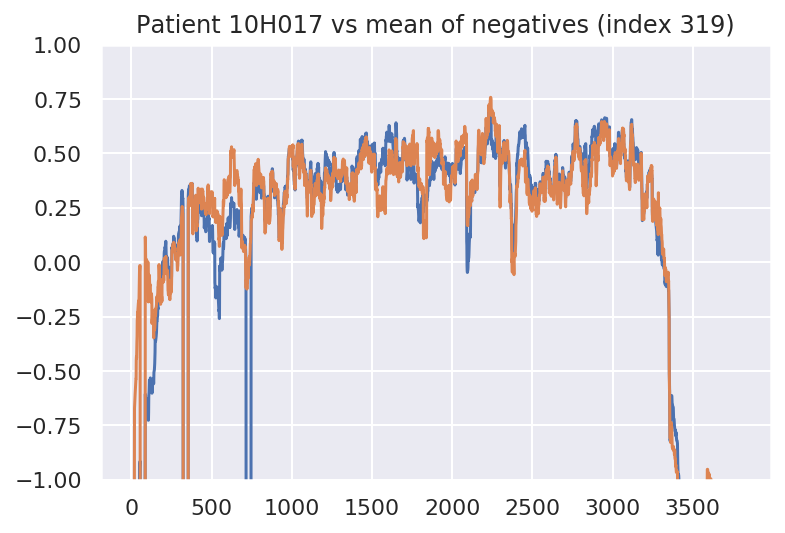

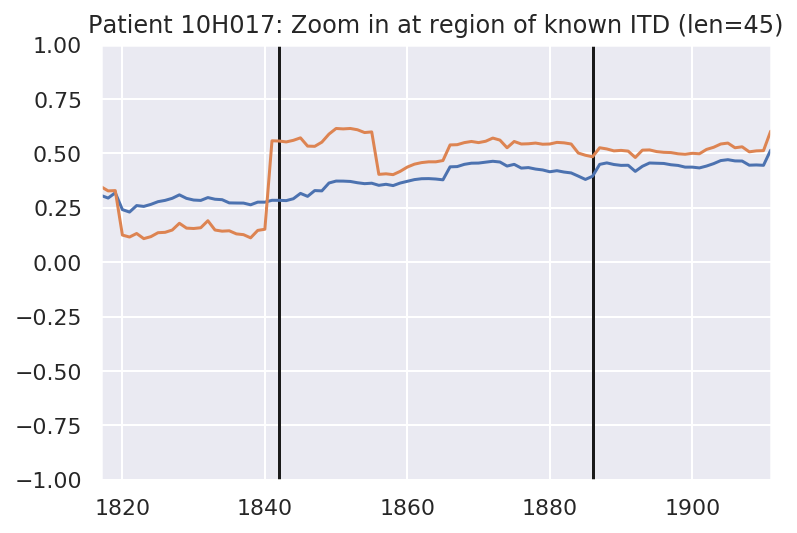

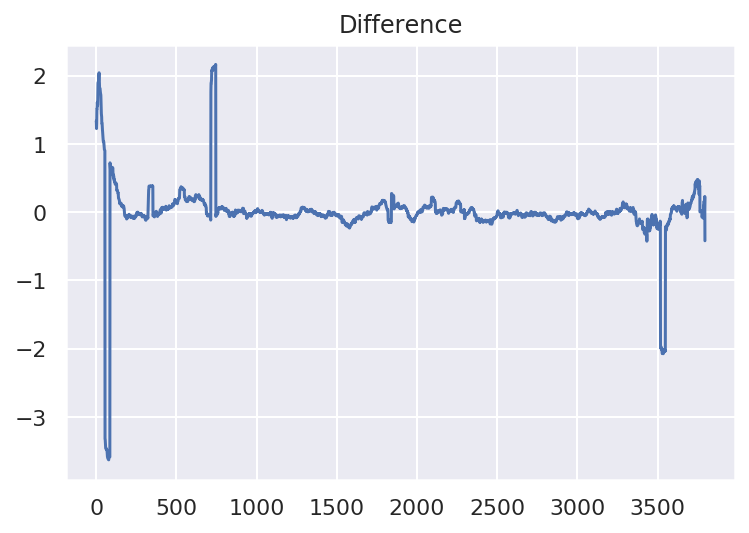

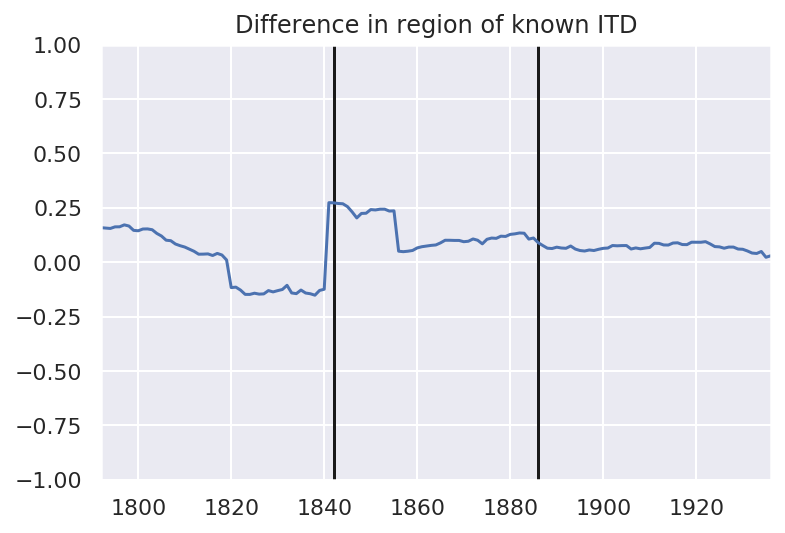

In [36]:
investigate_itd()

In [ ]:
# If you fix it, it doesn't work anymore
from flt3_data_loading import km_normed_1, flt3_filtered
with open('data/itd_table', 'rb') as f:
    itd_data = pickle.load(f)

detectable_itds = [patient for patient in list(itd_data.keys()) if itd_data[patient] != '' and itd_data[patient][2] >= 31]    

leucegene = pd.read_csv('data/leucegene.csv', index_col=0, skipfooter=1, engine='python')
flt3_patients = [itd_id for itd_id in list(leucegene.index) if leucegene.loc[itd_id]['FLT3-ITD mutation'] == '0' or leucegene.loc[itd_id]['FLT3-ITD mutation'] == '1']
def id_to_index(itd_id):
    # patient ID to index number in patient list of FLT3-ITD patients
    return flt3_patients.index(itd_id)

neg_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 0]
all_neg = km_normed_1.iloc[neg_indices]
neg_mean = np.array(np.mean(all_neg, axis=0))

def investigate_itd():
    # Generates graphs for random flt3-ITD positive patient with len(ITD) >= 31.
    itd_id = rand.choice(detectable_itds)
    itd_start, itd_end, itd_len = itd_data[itd_id]
    first = np.array(km_normed_1.iloc[id_to_index(itd_id)])
    plt.plot(neg_mean)
    plt.plot(first)
    plt.title(f"Patient {itd_id} vs mean of negatives")
    plt.show()
    plt.plot(neg_mean)
    plt.plot(first)
    plt.title(f"Zoom in at region of known ITD (len={itd_len})")
    plt.xlim(itd_start-25, itd_end+25)
    plt.vlines((itd_start, itd_end), -1, 1)
    plt.ylim(-1,1)
    plt.show()
    plt.plot(first - neg_mean)
    plt.title("Difference")
    plt.show()
    plt.plot(first - neg_mean)
    plt.title(f"Difference in region of known ITD (len={itd_len})")
    plt.xlim(itd_start-50, itd_end+50)
    plt.vlines((itd_start, itd_end), -1, 1)
    plt.ylim(-1,1)
    plt.show()

In [56]:
leucegene = pd.read_csv('data/leucegene.csv', index_col=0, skipfooter=1, engine='python')
pos_patients = list(leucegene['FLT3-ITD mutation'][leucegene['FLT3-ITD mutation'] == '1'].index)
itd_data = {}
p = 0
for pos_patient in pos_patients:
    cmd = f"km find_mutation /soft/bioinfo/linux_RH7/km-0.1.0-py27/km/data/catalog/GRCh38/FLT3-ITD_exons_13-15.fa /u/leucegene/data/sample/{pos_patient}/transcriptome/jellyfish/2.2.3/kmers.k31.CL2.jf"
    output = subprocess.getoutput(cmd)
    itd_data[pos_patient] = parse_km_output(output)
    p += 1
    print(f"\rProgress: {int(p/len(pos_patients)*100)}%", end='')

Progress: 100%

In [58]:
with open('data/itd_table', 'wb') as f:
    pickle.dump(itd_data, f)

In [6]:
from flt3_data_loading import km_normed_1, flt3_filtered
km_normed_1.shape, len(itd_data)

((452, 3796), 132)

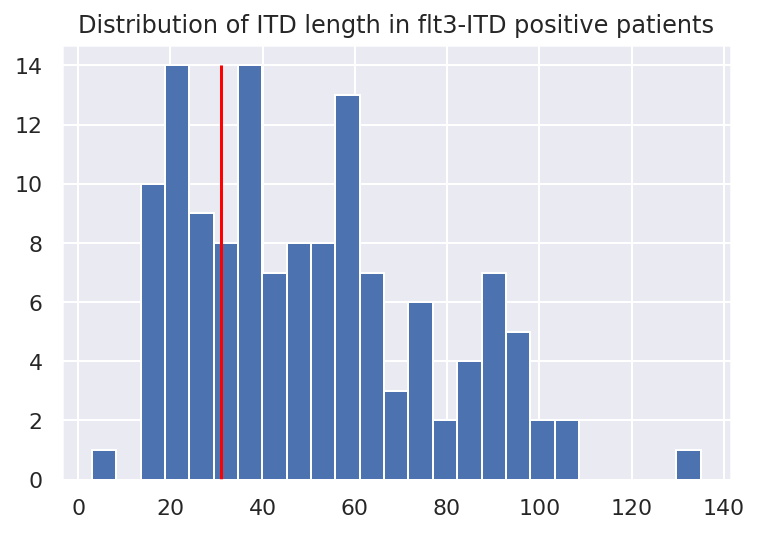

In [33]:
# plot ITD lengths
itd_lengths = [j[2] for j in [i for i in list(itd_data.values()) if i != '']]
plt.hist(itd_lengths, bins=25)
plt.vlines(31, 0, 14, color='red')
plt.title("Distribution of ITD length in flt3-ITD positive patients")
plt.show()

### Model

Epoch: 500	Train: 0.6563928027947744	Val: 0.7163425087928772	Min Val: 0.6935774981975555

 0.5398261852394917

 0.5379515599343185


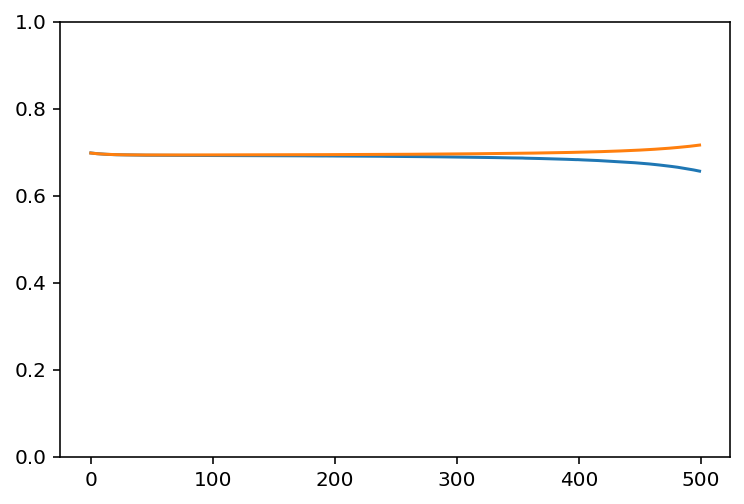

In [ ]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

# 4 layers sgd lr=0.01 and no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)
        #self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = F.relu(self.fc5(x))
        #x = self.dropout(x)
        x = self.fc6(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 500
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_flt3_0.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch+1}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
print("")
torch.save(model.state_dict(), 'model_files/model_flt3_0.pt')

try:
    # Final model
    model.load_state_dict(torch.load('model_files/model_flt3_0.pt'))
    from sklearn.metrics import roc_auc_score
    model.eval()
    score = 0
    for data, target in test_loader:
        data = data.to(device)
        pred = model.predict(data.float())
        pred.cpu()
        score += roc_auc_score(pred, target)*len(target)
        # print(roc_auc_score(pred, target))
        # print(pred)
        # print(target)
    print('\n', score/len(test_loader.sampler))
except:
    print("Predicted all 0...")

try:
    # Saved best model
    model.load_state_dict(torch.load('model_files/model_flt3_0.pt'))
    model.eval()
    score = 0
    for data, target in test_loader:
        data = data.to(device)
        data.float()
        pred = model.predict(data.float())
        pred.cpu()
        score += roc_auc_score(pred, target)*len(target)
        # print(roc_auc_score(pred, target))
        # print(pred)
        # print(target)
    print('\n', score/len(test_loader.sampler))
except:
    print("Predicted all 0...")

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()